# Expense Categorization using MiniLM Embeddings, SVM, XGBoost & Ensemble

## 1. Project Overview

This notebook implements an **expense categorization system** that predicts categories such as `Food`, `Transport`, `Shopping`, etc. from raw transaction descriptions (e.g., `"Uber ride to office"`, `"Starbucks latte"`).

The pipeline uses:

- **MiniLM Sentence Embeddings** (`all-MiniLM-L6-v2`) from `sentence-transformers`
- **SVM (RBF kernel)** with hyperparameter tuning
- **XGBoost** classifier
- **Ensemble model** combining SVM + XGBoost probabilities
- **Model evaluation** (accuracy, classification report, confusion matrix)
- **Error / mistake analysis** to inspect misclassified examples

The goal is to build a **practical, accurate, and explainable** classifier suitable for a personal finance assistant or agentic AI system.


In [10]:
# 2. Install dependencies (run once per environment)
!pip install -q sentence-transformers xgboost

## 3. Imports & Configuration

In [11]:
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

# Configuration
DATA_PATH = "expense_data.csv"  # Update path if needed
RANDOM_STATE = 42

## 4. Load & Clean Dataset

In [12]:
# Load dataset
df = pd.read_csv(DATA_PATH)

# Basic schema check
assert "Description" in df.columns and "Category" in df.columns,     "CSV must contain 'Description' and 'Category' columns."

# Drop missing values
df = df.dropna(subset=["Description", "Category"]).reset_index(drop=True)

print("Original category distribution:")
print(df["Category"].value_counts())

# Remove extremely rare categories (< 2 samples)
counts = df["Category"].value_counts()
rare = counts[counts < 2].index
print("\nDropping rare categories:", list(rare))

df = df[~df["Category"].isin(rare)].reset_index(drop=True)

print("\nUpdated category distribution:")
print(df["Category"].value_counts())

Original category distribution:
Category
Food                     16
Transport                12
Entertainment            11
Health & Fitness          9
Electronics               6
Household                 6
Travel                    6
Utilities                 5
Insurance                 5
Personal Care             5
Business Expenses         5
Education                 5
Clothing                  4
Gifts                     4
Software                  3
Books                     3
Rent                      2
Charity                   2
Professional Services     2
Pets                      2
Shopping                  1
Hobbies                   1
Debt Repayment            1
Marketing                 1
Name: count, dtype: int64

Dropping rare categories: ['Shopping', 'Hobbies', 'Debt Repayment', 'Marketing']

Updated category distribution:
Category
Food                     16
Transport                12
Entertainment            11
Health & Fitness          9
Household                 

## 5. Label Encoding & Train/Test Split

In [13]:
# Encode string labels -> numeric ids
le = LabelEncoder()
df["label"] = le.fit_transform(df["Category"])

X_text = df["Description"].astype(str).tolist()
y = df["label"].values

# Stratified train-test split to preserve label distribution
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Train size: {len(X_train_text)}, Test size: {len(X_test_text)}")
print("Classes:", list(le.classes_))

# Labels actually present in the test set (for clean reports)
test_labels = np.unique(y_test)
test_label_names = le.inverse_transform(test_labels)

Train size: 90, Test size: 23
Classes: ['Books', 'Business Expenses', 'Charity', 'Clothing', 'Education', 'Electronics', 'Entertainment', 'Food', 'Gifts', 'Health & Fitness', 'Household', 'Insurance', 'Personal Care', 'Pets', 'Professional Services', 'Rent', 'Software', 'Transport', 'Travel', 'Utilities']


## 6. MiniLM Embeddings

In [14]:
# Load MiniLM sentence embedding model
print("Loading MiniLM encoder...")
encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Encode train & test descriptions into dense vectors
print("\nEncoding training descriptions...")
X_train_emb = encoder.encode(
    X_train_text,
    batch_size=32,
    convert_to_numpy=True,
    show_progress_bar=True
)

print("\nEncoding test descriptions...")
X_test_emb = encoder.encode(
    X_test_text,
    batch_size=32,
    convert_to_numpy=True,
    show_progress_bar=True
)

print("\nTrain embedding shape:", X_train_emb.shape)
print("Test embedding shape:", X_test_emb.shape)

Loading MiniLM encoder...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Encoding training descriptions...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


Encoding test descriptions...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Train embedding shape: (90, 384)
Test embedding shape: (23, 384)


## 7. Feature Scaling for SVM

In [15]:
# SVM is sensitive to feature scale, so we standardize embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_emb)
X_test_scaled = scaler.transform(X_test_emb)

## 8. Train SVM with Hyperparameter Tuning (GridSearchCV)

In [16]:
svm = SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)

param_grid = {
    "C": [0.5, 1, 3, 5],
    "gamma": ["scale", 0.1, 0.01]
}

print("Running GridSearchCV for SVM...")

grid_svm = GridSearchCV(
    svm,
    param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train_scaled, y_train)

best_svm = grid_svm.best_estimator_
print("\nBest SVM parameters:", grid_svm.best_params_)

Running GridSearchCV for SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



Best SVM parameters: {'C': 3, 'gamma': 'scale'}


## 9. Train XGBoost Classifier

In [17]:
print("Training XGBoost classifier...")

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=RANDOM_STATE
)

xgb.fit(X_train_emb, y_train)

Training XGBoost classifier...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

## 10. Model Evaluation: SVM, XGBoost, and Ensemble

In [18]:
# ---- SVM Evaluation ----
y_pred_svm = best_svm.predict(X_test_scaled)
acc_svm = accuracy_score(y_test, y_pred_svm)

print("\n=================== SVM PERFORMANCE ===================")
print(f"Accuracy: {acc_svm:.4f}")
print(classification_report(
    y_test,
    y_pred_svm,
    labels=test_labels,
    target_names=test_label_names
))

# ---- XGBoost Evaluation ----
y_pred_xgb = xgb.predict(X_test_emb)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

print("\n=================== XGBOOST PERFORMANCE ===================")
print(f"Accuracy: {acc_xgb:.4f}")
print(classification_report(
    y_test,
    y_pred_xgb,
    labels=test_labels,
    target_names=test_label_names
))

# ---- Ensemble (Average Probabilities) ----
proba_svm = best_svm.predict_proba(X_test_scaled)
proba_xgb = xgb.predict_proba(X_test_emb)

proba_ensemble = (proba_svm + proba_xgb) / 2.0
y_pred_ens = np.argmax(proba_ensemble, axis=1)
acc_ens = accuracy_score(y_test, y_pred_ens)

print("\n=================== ENSEMBLE (SVM + XGBoost) PERFORMANCE ===================")
print(f"Accuracy: {acc_ens:.4f}")
print(classification_report(
    y_test,
    y_pred_ens,
    labels=test_labels,
    target_names=test_label_names
))


=================== SVM PERFORMANCE ===================
Accuracy: 0.6522
                       precision    recall  f1-score   support

                Books       0.00      0.00      0.00         1
    Business Expenses       0.00      0.00      0.00         1
             Clothing       0.00      0.00      0.00         1
            Education       1.00      1.00      1.00         1
          Electronics       0.00      0.00      0.00         1
        Entertainment       0.33      1.00      0.50         2
                 Food       0.75      1.00      0.86         3
                Gifts       0.00      0.00      0.00         1
     Health & Fitness       1.00      1.00      1.00         2
            Household       1.00      1.00      1.00         1
            Insurance       1.00      1.00      1.00         1
        Personal Care       0.00      0.00      0.00         1
Professional Services       0.00      0.00      0.00         1
             Software       0.00      0.00 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

## 11. Confusion Matrix (Ensemble)

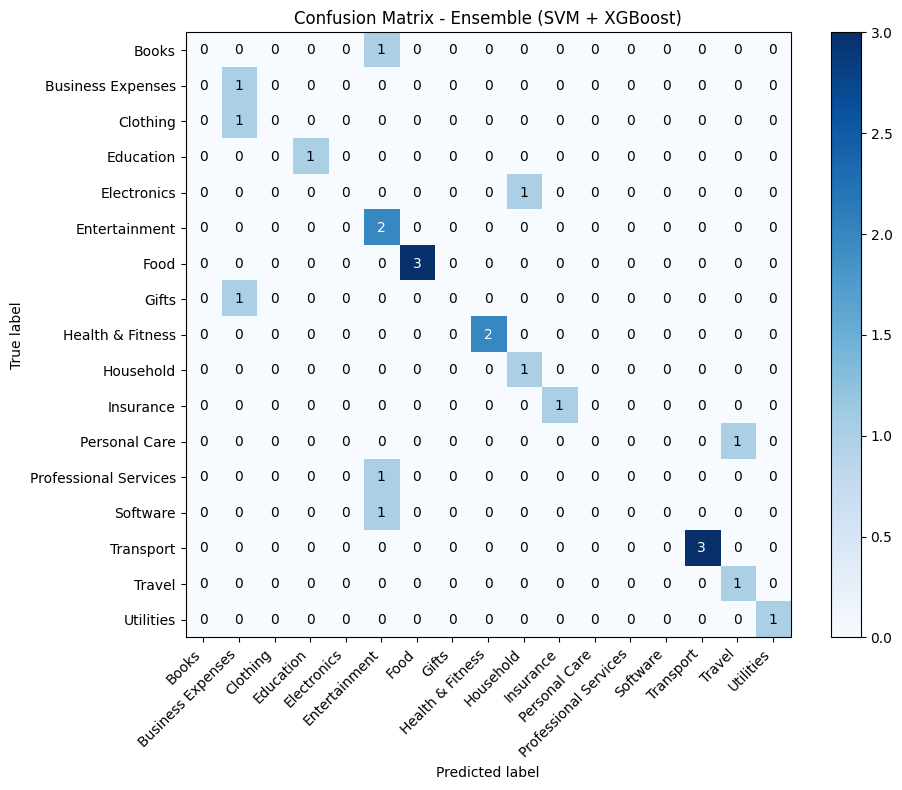

In [19]:
cm = confusion_matrix(y_test, y_pred_ens, labels=test_labels)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - Ensemble (SVM + XGBoost)")
plt.colorbar()

tick_marks = np.arange(len(test_label_names))
plt.xticks(tick_marks, test_label_names, rotation=45, ha="right")
plt.yticks(tick_marks, test_label_names)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

## 12. Mistake Analysis

In [20]:
results_df = pd.DataFrame({
    "Description": X_test_text,
    "True_label_id": y_test,
    "Pred_svm_id": y_pred_svm,
    "Pred_xgb_id": y_pred_xgb,
    "Pred_ens_id": y_pred_ens
})

results_df["True_label"] = le.inverse_transform(results_df["True_label_id"])
results_df["Pred_svm"] = le.inverse_transform(results_df["Pred_svm_id"])
results_df["Pred_xgb"] = le.inverse_transform(results_df["Pred_xgb_id"])
results_df["Pred_ens"] = le.inverse_transform(results_df["Pred_ens_id"])

mistakes = results_df[results_df["True_label"] != results_df["Pred_ens"]]

print("Number of misclassified examples (ensemble):", len(mistakes))
print("\nSample misclassifications:")
mistakes.head(15)[[
    "Description", "True_label", "Pred_svm", "Pred_xgb", "Pred_ens"
]]

Number of misclassified examples (ensemble): 7

Sample misclassifications:


,Description,True_label,Pred_svm,Pred_xgb,Pred_ens
3,Gift card purchase for employee,Gifts,Food,Business Expenses,Business Expenses
4,Weekend spa visit,Personal Care,Travel,Food,Travel
9,Subscription to cloud storage service,Software,Entertainment,Entertainment,Entertainment
10,Amazon purchase for home gadgets,Electronics,Entertainment,Household,Household
11,Magazine subscription for business trends,Books,Entertainment,Business Expenses,Entertainment
12,New laptop bag,Clothing,Electronics,Business Expenses,Business Expenses
18,Cost of attending a networking event,Professional Services,Entertainment,Entertainment,Entertainment


## 13. Helper Function for Single Prediction

In [21]:
def predict_category(description: str):
    """Predict expense category for a single description using the ensemble model."""
    emb = encoder.encode([description], convert_to_numpy=True)
    emb_scaled = scaler.transform(emb)

    proba_svm = best_svm.predict_proba(emb_scaled)
    proba_xgb = xgb.predict_proba(emb)
    proba_ensemble = (proba_svm + proba_xgb) / 2.0

    label_id = np.argmax(proba_ensemble, axis=1)[0]
    return le.inverse_transform([label_id])[0]

# Example
example = "Starbucks coffee and sandwich"
print("Description:", example)
print("Predicted category:", predict_category(example))

Description: Starbucks coffee and sandwich
Predicted category: Food
